# Benchmarking the Recovery of Known Drug Targets from L1000 CRISPR KO Data: Batch Version

In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, Markdown
import json
import requests
import time
from random import sample
from math import log2
from maayanlab_bioinformatics.dge import characteristic_direction, limma_voom
from maayanlab_bioinformatics.plotting

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [4]:
# Set parameters 
low_expression_threshold = 0.3

In [5]:
# Load in L1000 level 3 data links

l1000_data_dir = '../L1000_data'
l1000_data_file = 'NR1I2_L1000_CRISPRKO_fulldata.tsv'
l1000_meta_file = 'NR1I2_L1000_CRISPRKO_metadata.tsv'
l1000_ctrl_file = 'L1000_Controls_fulldata.tsv'

expr_df = pd.read_csv(f"{l1000_data_dir}/{l1000_data_file}", sep='\t', index_col=0)
expr_df.head()

,XPR010_A375.311_96H_X1_B35:F08,XPR010_A375.311_96H_X2_B35:F08,XPR010_A375.311_96H_X3_B35:F08,XPR010_A375.311_96H_X1_B35:F24,XPR010_A375.311_96H_X2_B35:F24,XPR010_A375.311_96H_X3_B35:F24,XPR010_A549.311_96H_X1.L2_B36:F08,XPR010_A549.311_96H_X3_B35:F08,XPR010_A549.311_96H_X1.L2_B36:F24,XPR010_A549.311_96H_X3_B35:F24,...,XPR010_U251MG.311_96H_X3_B35:F08,XPR010_U251MG.311_96H_X1_B35:F24,XPR010_U251MG.311_96H_X2_B35:F24,XPR010_U251MG.311_96H_X3_B35:F24,XPR010_YAPC.311_96H_X1_B35:F08,XPR010_YAPC.311_96H_X2_B35:F08,XPR010_YAPC.311_96H_X3_B35:F08,XPR010_YAPC.311_96H_X1_B35:F24,XPR010_YAPC.311_96H_X2_B35:F24,XPR010_YAPC.311_96H_X3_B35:F24
symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,6.158450,6.202200,6.285650,6.249500,6.071100,6.225575,6.03340,6.26310,6.29285,6.52600,...,6.41030,6.8449,6.698900,6.50580,6.553050,7.549575,6.84630,6.780425,6.951875,6.821550
PAX8,6.011775,6.106200,5.664900,5.665750,5.471950,5.780600,4.99225,5.30080,4.62410,4.82470,...,5.23020,4.5078,5.127000,5.00560,5.445525,5.153600,4.25930,5.035250,4.937550,4.004100
GUCA1A,4.835400,4.938175,4.842400,4.697725,4.872650,4.826450,5.21620,5.17145,4.99370,5.02665,...,4.89295,4.7672,4.806500,4.92165,5.290500,5.622600,5.89155,5.574350,5.208800,5.685100
EPHB3,6.632500,6.971400,6.574300,6.753650,6.427550,6.769800,8.29650,7.51050,7.67320,8.04430,...,8.03480,8.9509,7.990300,7.93880,7.675250,7.396850,6.47865,7.833150,7.967200,7.705101
ESRRA,7.819700,7.858900,8.497725,8.272900,8.056351,7.891300,8.73630,8.28170,8.84240,8.22250,...,7.25300,6.8591,7.123001,7.13630,8.613050,8.440750,7.94130,8.899151,8.561750,8.045325


In [6]:
meta_df = pd.read_csv(f"{l1000_data_dir}/{l1000_meta_file}", sep='\t', index_col=0)
meta_df['batch'] = meta_df.index.map(lambda x: '_'.join(x.split('_')[:3]))
meta_df.head()

,tissue,disease,cell_line,pert_name,pert_time,pert_type,data_level,creation_time,persistent_id,pert_dose,batch
id,,,,,,,,,,,
XPR010_A375.311_96H_X1_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X3_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X1_B35:F24,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:F24,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H


In [7]:
batches = meta_df['batch'].unique()
len(batches)

10

## Load in Control Data

In [8]:
ctrl_expr_df = pd.read_csv(f"{l1000_data_dir}/{l1000_ctrl_file}", sep='\t', index_col=0)
ctrl_expr_df.head()

,XPR010_A375.311_96H_X1_B35:A06,XPR010_A375.311_96H_X2_B35:A06,XPR010_A375.311_96H_X3_B35:A06,XPR010_A375.311_96H_X1_B35:D05,XPR010_A375.311_96H_X2_B35:D05,XPR010_A375.311_96H_X3_B35:D05,XPR010_A375.311_96H_X1_B35:D20,XPR010_A375.311_96H_X2_B35:D20,XPR010_A375.311_96H_X3_B35:D20,XPR010_A375.311_96H_X1_B35:D21,...,XPR010_YAPC.311_96H_X3_B35:E14,XPR010_YAPC.311_96H_X1_B35:F04,XPR010_YAPC.311_96H_X2_B35:F04,XPR010_YAPC.311_96H_X3_B35:F04,XPR010_YAPC.311_96H_X1_B35:H24,XPR010_YAPC.311_96H_X2_B35:H24,XPR010_YAPC.311_96H_X3_B35:H24,XPR010_YAPC.311_96H_X1_B35:K17,XPR010_YAPC.311_96H_X2_B35:K17,XPR010_YAPC.311_96H_X3_B35:K17
symbol,,,,,,,,,,,,,,,,,,,,,
NAT2,7.260575,7.280875,7.02010,6.966801,7.45305,7.79865,7.34975,7.165100,7.708175,7.48150,...,12.6010,8.773951,8.02120,12.157150,7.691299,7.311550,12.085751,8.362350,9.20055,11.97370
ADA,5.064700,5.259250,5.22435,5.144300,5.38295,5.03075,5.07075,5.199075,4.932025,5.28315,...,4.6644,4.806450,4.66950,3.391350,5.972750,5.615875,4.137550,6.133075,4.75340,4.23540
CDH2,5.706775,5.822050,5.69430,5.853000,5.64155,5.71160,5.98715,5.800150,5.671200,5.80255,...,6.0781,5.741250,5.86595,5.915725,5.294300,6.179800,6.161100,5.736300,5.83550,5.75765
AKT3,0.896850,2.521300,2.37685,1.295950,3.11635,2.51195,2.38330,1.790250,1.295950,3.40630,...,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
MED6,5.884050,5.757250,5.77825,5.589350,6.05750,5.44470,5.63980,5.929700,5.832875,5.86350,...,6.2660,5.605700,6.17515,5.849500,5.851400,6.168350,5.662300,5.871375,6.37535,6.18240


In [9]:
ctrl_meta_df = pd.read_csv(f"{l1000_data_dir}/L1000_NR1I2_Controls_metadata.tsv", sep='\t', index_col=0)
ctrl_meta_df.head()

,batch
id,
XPR010_A375.311_96H_X1_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X3_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X1_B35:D05,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:D05,XPR010_A375.311_96H


## Normalize Data

### Combine data and remove duplicate genes

In [16]:
combined_df = pd.concat([
    expr_df.groupby(expr_df.index).mean(), 
    ctrl_expr_df.groupby(ctrl_expr_df.index).mean()
], axis=1)
combined_df.head()

,XPR010_A375.311_96H_X1_B35:F08,XPR010_A375.311_96H_X2_B35:F08,XPR010_A375.311_96H_X3_B35:F08,XPR010_A375.311_96H_X1_B35:F24,XPR010_A375.311_96H_X2_B35:F24,XPR010_A375.311_96H_X3_B35:F24,XPR010_A549.311_96H_X1.L2_B36:F08,XPR010_A549.311_96H_X3_B35:F08,XPR010_A549.311_96H_X1.L2_B36:F24,XPR010_A549.311_96H_X3_B35:F24,...,XPR010_YAPC.311_96H_X3_B35:E14,XPR010_YAPC.311_96H_X1_B35:F04,XPR010_YAPC.311_96H_X2_B35:F04,XPR010_YAPC.311_96H_X3_B35:F04,XPR010_YAPC.311_96H_X1_B35:H24,XPR010_YAPC.311_96H_X2_B35:H24,XPR010_YAPC.311_96H_X3_B35:H24,XPR010_YAPC.311_96H_X1_B35:K17,XPR010_YAPC.311_96H_X2_B35:K17,XPR010_YAPC.311_96H_X3_B35:K17
symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,4.45315,4.23635,4.634250,3.93165,3.87275,3.75120,5.3409,4.67510,5.60880,5.23860,...,10.192900,10.741025,10.62880,10.17440,11.360250,10.609800,10.58320,11.2271,11.164000,10.640949
A2M,7.22560,7.47065,8.596849,7.24335,7.29490,7.76080,8.1608,5.55060,8.57160,5.88430,...,8.146475,7.649900,8.25165,8.60140,7.470325,7.525375,7.99345,7.0502,8.668000,8.725750
A4GALT,5.43295,5.44650,5.665200,5.29545,5.68145,5.51620,6.7321,6.05495,6.72805,5.74780,...,5.415850,6.452750,5.52640,5.43765,5.709750,6.054850,4.93555,6.1569,6.114300,4.902300
A4GNT,5.37260,5.28950,5.293250,5.18680,5.30390,5.38095,5.2655,5.52010,5.44740,5.62385,...,8.344800,8.872550,8.37400,8.79715,8.576900,8.662701,8.30970,8.8629,8.714951,8.285049
AAAS,7.51980,7.64780,7.956600,7.59620,8.07660,7.87480,8.1372,7.55920,8.28530,7.90890,...,6.719550,6.666550,6.71455,6.97565,6.509600,6.576250,6.78680,6.4280,6.527250,6.776250


In [17]:
datasets = {
    'metadata': meta_df, 
    'ctrl_metadata': ctrl_meta_df,
    'rawdata': combined_df
}

## Compute Signatures: Batch Perturbations vs. Batch Controls

In [18]:
batch_profiles = {x: {'perts': [], 'ctrls': []} for x in batches}
for b in batches: 
    batch_profiles[b]['perts'] = meta_df[meta_df['batch'] == b].index.tolist()
    batch_profiles[b]['ctrls'] = ctrl_meta_df[ctrl_meta_df['batch'] == b].index.tolist()

In [19]:
batch_signatures = {'cd': {}, 'limma': {}, 'fc': {}}

### Characteristic Direction

In [20]:
# Function for computing signatures with characteristic direction
def cd_signature(ctrl_ids, case_ids, dataset, normalization):
  
    signature = characteristic_direction(
        dataset[normalization].loc[:, ctrl_ids], 
        dataset[normalization].loc[:, case_ids], 
        calculate_sig=True
    )
    signature = signature.sort_values("CD-coefficient", ascending=False)
    
    return signature

Note: the following step may take a few minutes to run.

In [21]:
for b in batches: 
    batch_signatures['cd'][b] = cd_signature(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        datasets, 
        'rawdata'
    )

### Limma

In [22]:
# Function for computing signatures
def limma(ctrl_ids, case_ids, dataset, normalization):
    
    signature = limma_voom.limma_voom_differential_expression(
        dataset[normalization].loc[:, ctrl_ids],
        dataset[normalization].loc[:, case_ids],
        filter_genes=False
    )
    signature = signature.sort_values("t", ascending=False)

    return signature

Note: the following step may take a few minutes to run.

In [23]:
for b in batches: 
    batch_signatures['limma'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        datasets, 
        'rawdata'
    )

R[write to console]: Loading required package: R.oo

R[write to console]: Loading required package: R.methodsS3

R[write to console]: R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R[write to console]: R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.

R[write to console]: 
Attaching package: ‘R.oo’


R[write to console]: The following object is masked from ‘package:R.methodsS3’:

    throw


R[write to console]: The following objects are masked from ‘package:methods’:

    getClasses, getMethods


R[write to console]: The following objects are masked from ‘package:base’:

    attach, detach, load, save


R[write to console]: R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.

R[write to console]: 
Attaching package: ‘R.utils’


R[write to console]: The following object is masked from ‘package:utils’:

    timestamp


R[write to console]: The following objects are masked from

### Fold Change

In [24]:
# Function for computing signatures with fold change
def logFC(ctrl_ids, case_ids, dataset, normalization):

    case_mean = dataset[normalization].loc[:, case_ids].mean(axis=1)
    ctrl_mean = dataset[normalization].loc[:, ctrl_ids].mean(axis=1)
    
    signature = case_mean / ctrl_mean
    
    return signature.apply(lambda x: log2(x+0.001)).sort_values(ascending=False)

In [25]:
for b in batches: 
    batch_signatures['fc'][b] = logFC(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        datasets,
        'rawdata'
    )

## All signatures

In [26]:
batch_signatures['cd_all']= pd.concat([
    df[['CD-coefficient']].rename(columns={'CD-coefficient': b}) for (b, df) in batch_signatures['cd'].items()
], axis=1).sort_index()
batch_signatures['limma_all'] = pd.concat([
    df[['t']].rename(columns={'t': b}) for (b, df) in batch_signatures['limma'].items()
], axis=1).sort_index()
batch_signatures['fc_all'] = pd.concat([
    df.rename(b) for b, df in batch_signatures['fc'].items()
], axis=1).sort_index()

for k in batch_signatures.keys(): 
    if k.endswith('_all'): 
        method = k.split('_')[0].upper()
        display(Markdown(f"All {method} batch signatures"))
        display(batch_signatures[k])

All CD batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
symbol,,,,,,,,,,
A1CF,-0.019577,-0.016974,-0.015616,-0.016290,-0.020444,-0.018519,-0.017728,-0.020971,-0.017763,-0.019295
A2M,0.003215,-0.003538,0.001771,-0.001684,-0.001222,-0.002409,0.001087,0.002743,0.001958,0.004480
A4GALT,-0.000740,0.000667,0.000689,0.002151,0.000054,-0.001610,-0.000614,0.000041,-0.000140,0.000447
A4GNT,-0.011040,-0.008234,-0.014184,-0.013903,-0.014138,-0.015587,-0.013585,-0.012055,-0.013713,-0.009598
AAAS,0.004927,0.005585,0.005249,0.003679,0.005078,0.004642,0.005265,0.004076,0.004921,0.003304
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.000307,-0.001142,-0.000563,-0.000166,-0.001886,-0.001636,-0.000132,-0.000568,-0.001656,0.000642
ZXDC,-0.004677,-0.009372,-0.007265,-0.002839,-0.005829,-0.001725,-0.007841,-0.008623,-0.010583,-0.009344
ZYX,0.018972,0.014685,0.018484,0.012741,0.019393,0.011563,0.008750,0.022170,0.016844,0.015572


All LIMMA batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
A1CF,-60.019539,-28.815911,-44.964117,-42.496500,-76.125622,-40.349357,-38.287313,-65.604340,-55.876038,-43.141008
A2M,4.845533,-1.847583,3.406957,-2.852660,-2.416547,-0.537058,1.565255,9.006032,3.824993,2.729793
A4GALT,-3.617646,-1.016386,0.559526,6.139557,-2.310624,-4.533725,-3.529359,0.950890,-2.583732,2.579730
A4GNT,-42.919025,-19.718965,-50.182363,-30.878052,-47.377980,-36.774901,-24.278347,-24.678781,-38.743252,-27.158267
AAAS,26.282910,13.767572,18.236763,14.897501,24.929960,13.017880,16.846031,16.416623,23.690760,14.218616
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.235291,-2.809396,-0.987368,1.787694,-6.089417,-4.552719,-0.102972,-0.915882,-4.805944,-6.810436
ZXDC,-16.760846,-11.868575,-15.712726,-6.614901,-12.108318,-1.424355,-16.841576,-23.859809,-22.600620,-8.387029
ZYX,36.112290,13.855560,23.705964,20.629454,37.057409,15.960206,11.385518,35.864251,30.875875,25.291581
ZZEF1,-19.567202,-7.184474,-1.622090,-7.559272,-15.772091,-9.197690,3.419958,-8.114486,-3.014485,-9.025222


All FC batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
symbol,,,,,,,,,,
A1CF,-1.418332,-1.040272,-1.136226,-1.194198,-1.601675,-1.222738,-1.217520,-1.387034,-1.239450,-1.206063
A2M,0.157266,-0.123163,0.240870,-0.164634,-0.072182,-0.026677,0.108978,0.272596,0.159253,0.225869
A4GALT,-0.076240,-0.044683,0.009301,0.139864,-0.056234,-0.118184,-0.108340,0.020024,-0.071076,0.106850
A4GNT,-0.767693,-0.735056,-0.931857,-0.862885,-0.898295,-0.979380,-0.801131,-0.709310,-0.933009,-0.580846
AAAS,0.345681,0.417361,0.329596,0.214427,0.396350,0.324106,0.314611,0.238884,0.326043,0.263942
...,...,...,...,...,...,...,...,...,...,...
ZXDB,-0.002925,-0.080670,-0.024100,0.027726,-0.114968,-0.109545,-0.005998,-0.023018,-0.091592,-0.145058
ZXDC,-0.340634,-0.592188,-0.441215,-0.241991,-0.334266,-0.054244,-0.550736,-0.568386,-0.568292,-0.347858
ZYX,1.163029,0.813722,1.214162,0.733082,1.197966,0.854732,0.506321,1.124261,1.042311,1.013207


## Enrichment Analysis Rankings

In [27]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, library_name, signame, method, direction):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(enrichr_gene_list)
    description = f'Dex benchmark {signame} {method} {direction} genes'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error uploading gene list')

    list_data = json.loads(response.text)
    time.sleep(0.5)
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    response = requests.get(
        ENRICHR_URL + f"?userListId={list_data['userListId']}&backgroundType={library_name}"
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    enrich_data = json.loads(response.text)
    results_df  = pd.DataFrame(enrich_data[library_name])
    all_ranks.append(list(results_df[0]))
    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    all_adjusted_pvalues.append(list(results_df[6]))

    res_dict = {
        'ranks': all_ranks, 
        'terms': all_terms, 
        'pvals': all_pvalues,
        'adjpvals': all_adjusted_pvalues, 
        'shortid': str(list_data['shortId'])
    }

    return res_dict

In [28]:
# Get gene lists to put into Enrichr
gene_lists = {}
for m in batch_signatures.keys():
    if 'all' in m:
        mname = m.split('_')[0]
        gene_lists[mname] = {'up': {}, 'down': {}, 'combined': {}}
        for sig in batch_signatures[m]: 
            gene_lists[mname]['up'][sig] = batch_signatures[m][sig].sort_values(ascending=False).index.tolist()[:250]
            gene_lists[mname]['down'][sig] = batch_signatures[m][sig].sort_values(ascending=True).index.tolist()[:250]
            gene_lists[mname]['combined'][sig] = gene_lists[mname]['up'][sig] + gene_lists[mname]['down'][sig]

In [29]:
# Get results
results = {}
for m in gene_lists.keys():
    results[m] = {'up': {}, 'down': {}, 'combined': {}}
    for d in gene_lists[m].keys():
        for sig in gene_lists[m][d].keys():
            results[m][d][sig]= Enrichr_API(
                gene_lists[m][d][sig], 'ChEA_2022', sig, m, d
            )

In [ ]:
# Extract dexamethasone target rankings
# Initialize lists for storing target information
ranks = []
target = 'NR1I2'

In [41]:
display(Markdown(f"## {target} Term Rankings"))

## NR1I2 Term Rankings

In [30]:
for m in results.keys(): 
    for d in results[m].keys():
        for sig in results[m][d].keys():
            for i in range(len(results[m][d][sig]['ranks'][0])): 
                if target in results[m][d][sig]['terms'][0][i]: 
                    ranks.append([
                        f"{sig}:{m}:{d}",
                        results[m][d][sig]['terms'][0][i], 
                        results[m][d][sig]['ranks'][0][i],
                        results[m][d][sig]['pvals'][0][i]
                    ])
full_df = pd.DataFrame(ranks, columns=['Gene_Set', 'Term', 'Rank', 'p-value'])
full_df['Method'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[1])
full_df['Direction'] = full_df['Gene_Set'].apply(lambda x : x.split(':')[2])
full_df['Method_Direction'] = full_df.apply(lambda row: row['Method'] + ':' + row['Direction'], axis=1)

In [31]:
up_df = full_df[full_df['Direction']=='up']
down_df = full_df[full_df['Direction']=='down']
combined_df = full_df[full_df['Direction']=='combined']

In [32]:
display(Markdown(f"Mean rank of {target} terms from ChEA 2022 for up genes from each method."))
display(up_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown(f"Mean rank of {target} terms from ChEA 2022 for down genes from each method."))
display(down_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown(f"Mean rank of {target} terms from ChEA 2022 for combined up and down genes from each method."))
display(combined_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))

Mean rank of NR1I2 terms from ChEA 2022 for up genes from each method.

,Rank
Method,
limma,552.3
fc,575.6
cd,620.9


Mean rank of NR1I2 terms from ChEA 2022 for down genes from each method.

,Rank
Method,
cd,57.0
limma,126.6
fc,182.5


Mean rank of NR1I2 terms from ChEA 2022 for combined up and down genes from each method.

,Rank
Method,
cd,330.7
fc,369.2
limma,373.8


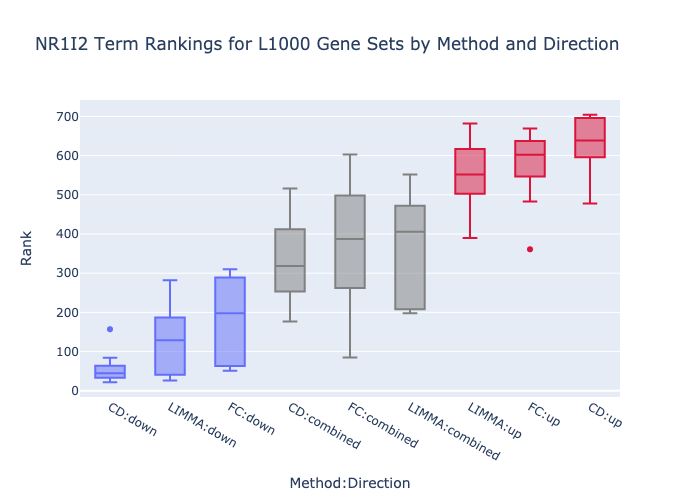

In [39]:
color_dict = {
    'up': 'crimson',
    'down': '#636EFA', 
    'combined': 'gray'
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.split(':')[0].upper() + ':' + gs.split(':')[1],
            marker_color=color_dict[gs.split(':')[1]]
        )
    )
fig1.update_layout(
    title_text=f"{target} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.show("png")

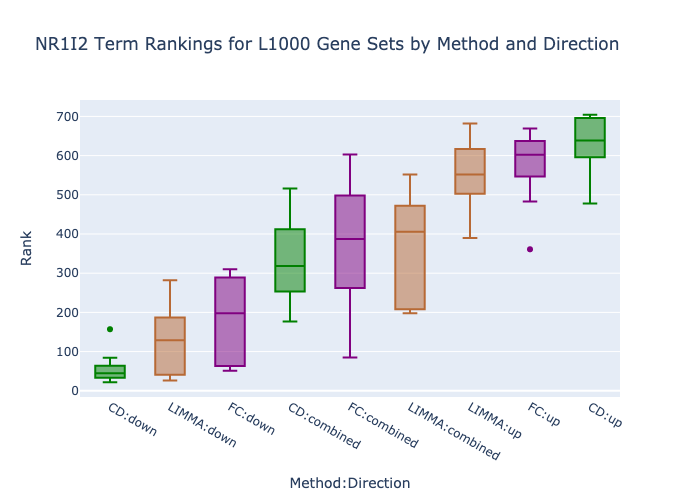

In [34]:
color_dict = {
    'cd': 'green',
    'limma': '#b76935', 
    'fc': 'purple'
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.split(':')[0].upper() + ':' + gs.split(':')[1],
            marker_color=color_dict[gs.split(':')[0]]
        )
    )
fig1.update_layout(
    title_text=f"{target} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.show("png")

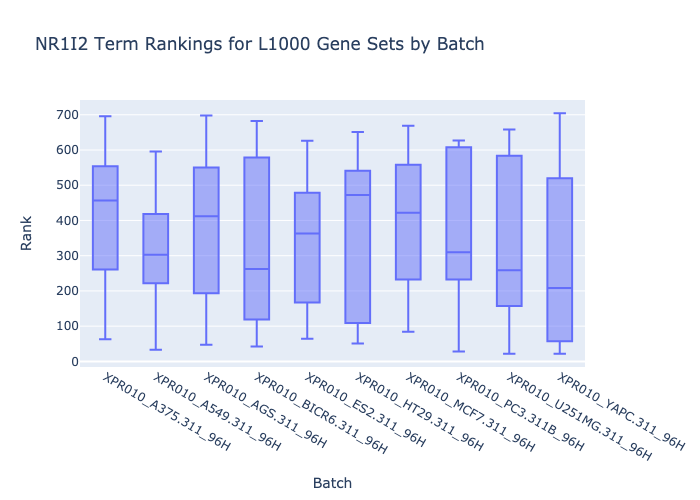

In [37]:
full_df['Batch'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[0])
fig1 = go.Figure()
for gs in full_df['Batch'].unique():
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Batch']==gs]['Rank'].tolist(),
            name=gs,
            marker_color='#636EFA'
        )
    )
fig1.update_layout(
    title_text=f"{target} Term Rankings for L1000 Gene Sets by Batch",
    xaxis={
        'title': {'text': 'Batch'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.show("png")

## Bridge plots

In [53]:
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt

In [43]:
def getEnrichrGeneSets(libname, termlist): 
    term_dict = {}
    liburl = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={libname}'
    response = requests.get(liburl)
    if not response.ok:
        raise Exception('Error fetching library from Enrichr')
    for term in termlist:
        geneset = response.json()[libname]['terms'][term].keys()
        term_dict[term] = geneset
    return term_dict

target_genesets = getEnrichrGeneSets('ChEA_2022', full_df['Term'].unique())

In [44]:
batch_signatures.keys()

dict_keys(['cd', 'limma', 'fc', 'cd_all', 'limma_all', 'fc_all'])

In [45]:
full_df.head()

,Gene_Set,Term,Rank,p-value,Method,Direction,Method_Direction,Batch
0,XPR010_A375.311_96H:cd:up,NR1I2 20693526 ChIP-Seq LIVER Mouse,696,0.957552,cd,up,cd:up,XPR010_A375.311_96H
1,XPR010_A549.311_96H:cd:up,NR1I2 20693526 ChIP-Seq LIVER Mouse,596,0.534017,cd,up,cd:up,XPR010_A549.311_96H
2,XPR010_AGS.311_96H:cd:up,NR1I2 20693526 ChIP-Seq LIVER Mouse,698,0.898930,cd,up,cd:up,XPR010_AGS.311_96H
3,XPR010_BICR6.311_96H:cd:up,NR1I2 20693526 ChIP-Seq LIVER Mouse,479,0.266417,cd,up,cd:up,XPR010_BICR6.311_96H
4,XPR010_ES2.311_96H:cd:up,NR1I2 20693526 ChIP-Seq LIVER Mouse,626,0.677980,cd,up,cd:up,XPR010_ES2.311_96H


In [47]:
batch_signatures['cd_all'].mean(axis=1)

symbol
A1CF     -0.018318
A2M       0.000640
A4GALT    0.000094
A4GNT    -0.012604
AAAS      0.004673
            ...   
ZXDB     -0.000680
ZXDC     -0.006810
ZYX       0.015917
ZZEF1    -0.002933
ZZZ3      0.004053
Length: 12327, dtype: float64

In [51]:
def singleBridgePlot(gsname, method, abs_val=False):
    geneset = target_genesets[gsname]

    if abs_val:
        abs_vals = batch_signatures[f"{method}_all"].mean(axis=1).apply(abs).sort_values(ascending=False)
        select = pd.Series(
            [x.upper() in geneset for x in abs_vals.index.tolist()]
        )
    else:
        select = pd.Series(
            [x.upper() in geneset for x in batch_signatures[f'{method}_all'].mean(axis=1).sort_values(ascending=False).index.tolist()]
        )
    x, y = bridge_plot(select)
    x = x/len(x)
    return x,y

def randomBridgePlot(gsname): 
    all_x = []
    all_y = []

    for _ in range(10):
        rand_sig = sample(
            batch_signatures['cd_all'].index.tolist(), 
            batch_signatures['cd_all'].shape[0]
        )
        select = pd.Series([
            x.upper() in target_genesets[gsname] for x in rand_sig
        ])
        x, y = bridge_plot(select)
        x = x/len(x)
        all_x.append(x)
        all_y.append(y)

    return all_x, all_y

In [52]:
def build_res(abs_val=False):
    res = {}
    for term in target_genesets.keys():
        res[term] = {'random': {'x': [], 'y': []}}
        rand_x, rand_y = randomBridgePlot(term)
        res[term]['random']['x'] += rand_x
        res[term]['random']['y'] += rand_y
        for method in batch_signatures.keys():
            if 'all' not in method:
                temp_x, temp_y = singleBridgePlot(term, method, abs_val=abs_val)
                if method in res[term].keys():
                    res[term][method]['x'].append(temp_x)
                    res[term][method]['y'].append(temp_y)
                else: 
                    res[term][method] = {'x': [temp_x], 'y': [temp_y]}
    return res

method_results = build_res(abs_val=False)
method_results_abs = build_res(abs_val=True)

In [54]:
def methodBridgePlot(abs_val=False):
    if abs_val:
        res = method_results_abs
    else: 
        res = method_results
    for term in res.keys():
        for sig in res[term].keys(): 
            term_x = np.mean(res[term][sig]['x'], axis=0)
            term_y = np.mean(res[term][sig]['y'], axis=0)
            if sig == 'random': 
                plt.plot(term_x, term_y, label=sig, color='gray')
            elif sig == 'CD': 
                plt.plot(term_x-(0.01*max(term_x)), term_y, label=sig)
            else:
                plt.plot(term_x, term_y, label=sig)

        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.legend(bbox_to_anchor=(1, 1))
        if abs_val:
            plt.title(f"{term.split(' ')[0]} Target Gene Rankings for Each Method (Abs Val)")
        else:
            plt.title(f"{term.split(' ')[0]} Target Gene Rankings for Each Method")
        plt.show()

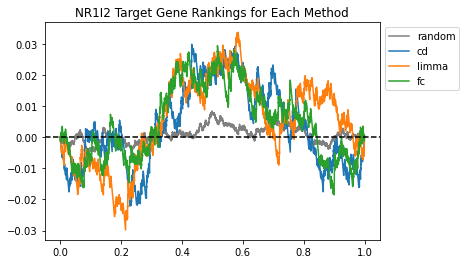

In [56]:
methodBridgePlot()

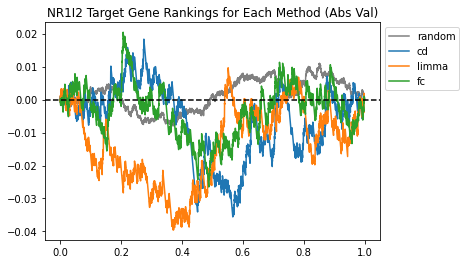

In [57]:
methodBridgePlot(abs_val=True)